# Genetic Algorithm Approach

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Hyperparameters

In [3]:
n_qubits = 4

In [4]:
n_train = 500
n_test = 100
batch_size = 32
n_epochs = 10

resized_dims_xy = 8
out_dims_xy = resized_dims_xy // 2

lr = 0.005

In [5]:
np.random.seed(137)  

In [6]:
n_generations = 10
population_size = 500
n_gates = 10
mutation_rate = .15

## Auxiliary Functions

In [7]:
def get_population_fitnesses(population):
    return list(map(lambda x: x[1], population))

In [8]:
def encode_gate(gate):
    if isinstance(gate, qml.RX):
        return 100 + gate.wires[0] * 10 
    elif isinstance(gate, qml.RZ):
        return 200 + gate.wires[0] * 10 
    elif isinstance(gate, qml.CNOT):
        return 300 + gate.wires[0] * 10 + gate.wires[1] * 1 
    elif isinstance(gate, qml.Hadamard):
        return 400 + gate.wires[0] * 10 
    else:
        print(gate)
        raise Exception("Invalid gate")
    
def decode_gate(encoded_gate, param):
    """
    D D D
        - Gate   [1..4]
        - Wire 1 [0..N_QUBITS-1]
        - Wire 2 [0..N_QUBITS-1]
    """
    encoded_gate = int(encoded_gate.item()) # Convert tensor to int to be able to use adjoint differentiation
    wire2  = encoded_gate % 10
    wire1 = (encoded_gate // 10) % 10
    gate = (encoded_gate // 100) % 10
    
    if gate == 1:
        return qml.RX(param, wires=wire1)
    elif gate == 2:
        return qml.RZ(param, wires=wire1)
    elif gate == 3:
        return qml.CNOT(wires=[wire1, wire2])
    elif gate == 4:
        return qml.Hadamard(wires=wire1)
    else:
        print(encoded_gate)
        raise Exception("Invalid gate")

## Genetic Algorithm Components

In [9]:
# Rotation      -> RX, RZ.
# Entanglement  -> CNOT.
# Superposition -> Hadamard.

parametrized_gates = [qml.RX, qml.RZ] # 1X0, 2X0
gates = parametrized_gates + [qml.Hadamard, qml.CNOT] # 4X0, 3XX

In [10]:
def get_random_gate():
    gate = np.random.randint(1, 5) # 1..4
    wire1 = np.random.randint(0, n_qubits) # 0..3
    wire2 = np.random.randint(0, n_qubits) # 0..3
    if gate == 3:
        while wire1 == wire2:
            wire2 = np.random.randint(0, n_qubits)
              
    return 100 * gate + 10 * wire1 + wire2

In [11]:
def generate_circuit(n_gates):
    circuit = []
    n_weights = 0
    fitness = 0
    for _ in range(n_gates):
        gate = get_random_gate()
        if (gate // 100) % 10 in [1, 2]:
            n_weights += 1
        circuit.append(gate)
    return (circuit, fitness, n_weights) 

In [12]:
def generate_population(n_circuits, n_gates):
    population = [None] * n_circuits
    for i in range(n_circuits):
        population[i] = generate_circuit(np.random.randint(2, n_gates))
    return population

In [13]:
def stochastic_universal_sampling(fitness_scores, n_samples):
    """Performs selection using Stochastic Universal Sampling.

    Args:
        fitness_scores: A NumPy array of fitness scores.
        num_samples: The number of individuals to select.

    Returns:
        A NumPy array containing the indices of the selected individuals.
    """

    total_fitness = np.sum(fitness_scores)
    fitness_scores = np.array(fitness_scores) 

    fitness_scores = fitness_scores / total_fitness

    # Cumulative sum of fitness scores
    cumulative_fitness = np.cumsum(fitness_scores)

    # Starting point for the first pointer
    start_point = np.random.uniform(0, 1/n_samples)

    # Generate equally spaced pointers
    pointers = np.arange(start_point, 1, 1/n_samples)

    # Select individuals based on the pointers' locations
    selected_indices = np.searchsorted(cumulative_fitness, pointers)

    return selected_indices 

def boltzmann_selection(fitness_scores, temperature, n_samples):
    """Selects individuals based on Boltzmann selection probabilities.

    Args:
        fitness_scores: The fitness scores of each individual.
        temperature: The temperature parameter for Boltzmann selection.
        n_samples: The number of individuals to select.

    Returns:
        A list of indices of the selected individuals.
    """

    # Calculate Boltzmann probabilities
    probabilities = np.exp(fitness_scores / temperature)
    probabilities /= np.sum(probabilities) 

    # Select individuals based on probabilities
    selected_indices = np.random.choice(
        len(fitness_scores), size=n_samples, p=probabilities
    )

    return selected_indices

In [14]:
def count_weights(circuit):
    return sum([1 for gate in circuit if (gate // 100) % 10 in [1, 2]])

In [15]:
def uniform_crossover(parent1, parent2, mixing_ratio=0.5):
    """Performs uniform crossover between two parent arrays (potentially different lengths)."""

    size1 = len(parent1)
    size2 = len(parent2)
    min_size = min(size1, size2)

    offspring1 = []
    offspring2 = []

    # Crossover for the shared portion of the genome
    for i in range(min_size):
        if np.random.random() < mixing_ratio:
            offspring1.append(parent1[i])
            offspring2.append(parent2[i])
        else:
            offspring1.append(parent2[i])
            offspring2.append(parent1[i])

    # Remaining genes from the longer parent 
    offspring1.extend(parent1[min_size:])  
    offspring2.extend(parent2[min_size:])  

    return (offspring1, 999, count_weights(offspring1)), (offspring2, 999, count_weights(offspring2)) 

In [16]:
def select_circuits(population, n_selected):
    fitness_values = get_population_fitnesses(population)
    selected_indices = stochastic_universal_sampling(fitness_values, n_selected)
    return [population[i] for i in selected_indices]

In [17]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(n_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    weight_index = 0
    for i in range(n_qubits, len(inputs)):
        gate = decode_gate(inputs[i], weights[weight_index])
        weight_index += 1
        qml.apply(gate)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [18]:
def extract_image_patches(x):
    # Do TF 'SAME' Padding
    B, C, H, W = x.shape  
    #x = torch.arange(B*C*H*W).view(B, C, H, W)
    kernel_h, kernel_w = 2, 2
    stride = 2

    patches = x.unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
      
    patches = patches.contiguous().view(B, H // stride, W // stride, -1)

    return patches.reshape(-1, 4)

In [19]:
class HQNN(nn.Module):
    def __init__(self, qlayer, gates):
        super(HQNN, self).__init__()

        # Quanvolutional layer (Maps 1 input channel to 4 output channels)
        self.quanv = qlayer
        self.gates = gates

        # Fully connected layer to perform the final classification
        self.fc1 = nn.Linear(out_dims_xy * out_dims_xy * 4, 10)  # Assuming 10 output classes

    def forward(self, input):
        patches = extract_image_patches(input)  

        tensor_gates = torch.tensor(self.gates)
        quanvoluted_patches = torch.stack([self.quanv(torch.cat((patch, tensor_gates))) for patch in patches])
        x = quanvoluted_patches.reshape(input.shape[0], out_dims_xy, out_dims_xy, 4)

        x = x.view(-1, out_dims_xy * out_dims_xy * 4)  # Flatten for the fully connected layer
        x = self.fc1(x)
        x = F.softmax(x, dim=1)  # Apply softmax
        return x

In [20]:
def load_dataset(n_train, n_test, batch_size):
    """
    Loads train & test sets from MNIST with user-specified sizes.

    Args:
        n_train (int): Desired number of samples in the training set.
        n_test (int): Desired number of samples in the testing set.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: (train_loader, test_loader) where each loader is a
               torch.utils.data.DataLoader.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.1381,)),
                                    transforms.Lambda(lambda img: F.interpolate(img.unsqueeze(0), size=(resized_dims_xy, resized_dims_xy), 
                                        mode='bilinear', align_corners=False).squeeze(0))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Subset the datasets to the desired number of samples
    train_subset = torch.utils.data.Subset(train_dataset, range(n_train))
    test_subset = torch.utils.data.Subset(test_dataset, range(n_test))

    # Create DataLoaders for training and testing sets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    print("Number of training samples:", len(train_subset))
    print("Number of test samples:", len(test_subset))

    return train_loader, test_loader

train_loader, test_loader = load_dataset(n_train, n_test, batch_size)

Number of training samples: 500
Number of test samples: 100


In [21]:
def fitness(individual):
    param_shapes = {"weights": (len(individual[0]),)}
    
    qlayer = qml.qnn.TorchLayer(circuit, weight_shapes=param_shapes)
    model = HQNN(qlayer, individual[0])
    loss_fn = F.cross_entropy
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94) 

#    model.fc1.load_state_dict(torch.load("mnist_params.pth"))
 
#    for param in model.fc1.parameters():
#        param.requires_grad = False
        
    for _ in range(n_epochs):
        #start_time = time.time()
        # ---- Training Phase ----
        running_loss = 0.0 

        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        #print(f"Time per epoch: {time.time() - start_time}s")
        
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradients for evaluation
        val_correct = 0
        val_total = 0

        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    
    #print(model.quanv.weights)
    
    return (individual[0], -val_acc, individual[2])

In [22]:
def insert_random_gate(circuit):
    mutated_circuit = circuit.copy()    
    mutated_circuit.append(get_random_gate())
    return mutated_circuit

def delete_random_gate(circuit):
    mutated_circuit = circuit.copy()    
    mutated_circuit.remove(random.choice(mutated_circuit))
    return mutated_circuit

def swap_random_gates(circuit):
    mutated_circuit = circuit.copy()    
    i, j = np.random.choice(range(len(mutated_circuit)), 2, replace=False)
    gate1 = mutated_circuit[i]
    gate2 = mutated_circuit[j]
    
    gate1_1 = (gate1 // 100) % 10
    wire1_1 = (gate1 // 10) % 10
    wire1_2 = gate1 % 10
    
    gate2_2 = (gate2 // 100) % 10
    wire2_1 = (gate2 // 10) % 10
    wire2_2 = gate2 % 10
    
    if gate1_1 == 3:
        while wire2_1 == wire2_2:
            wire2_2 = np.random.randint(0, n_qubits)
    
    if gate2_2 == 3:
        while wire1_1 == wire1_2:
            wire1_2 = np.random.randint(0, n_qubits)
    
    mutated_circuit[i] = 100 * gate2_2 + 10 * wire1_1 + wire1_2
    mutated_circuit[j] = 100 * gate1_1 + 10 * wire2_1 + wire2_2
    return mutated_circuit

def move_random_gate(circuit):
    mutated_circuit = circuit.copy()    
    i = np.random.choice(range(len(mutated_circuit)))
    encoded_gate = mutated_circuit[i]
    
    gate1_1 = (encoded_gate // 100) % 10
    wire1_1 = (encoded_gate // 10) % 10
    wire1_2 = encoded_gate % 10
    
    new_wire1 = np.random.choice(range(n_qubits))
    new_wire2 = np.random.choice(range(n_qubits))
    if gate1_1 == 3:
        while new_wire1 == new_wire2:
            new_wire2 = np.random.randint(0, n_qubits)
    new_gate = 100 * gate1_1 + 10 * new_wire1 + new_wire2
    
    mutated_circuit[i] = new_gate
    return mutated_circuit

def replace_random_gate(circuit):
    mutated_circuit = circuit.copy()    
    i = np.random.choice(range(len(mutated_circuit)))
    mutated_circuit[i] = get_random_gate()
    return mutated_circuit

In [23]:
def mutate_circuit(circuit):  
    op_thresholds = [0.2, 0.4, 0.6, 0.8]
    #op_choices = ["insert", "delete", "swap", "replace"]

    n_mutations = 1
    while np.random.random() < 0.1:
        n_mutations += 1

    for _ in range(n_mutations):
        op = np.random.random()

        # Insert a random gate
        if op < op_thresholds[0]:
            mutated_circuit = insert_random_gate(circuit)
        # Delete a random gate
        elif op < op_thresholds[1]:
            mutated_circuit = delete_random_gate(circuit)
        # Swap two random gates
        elif op < op_thresholds[2]:
            mutated_circuit = swap_random_gates(circuit)
        # Move a random gate to a random position
        elif op < op_thresholds[3]:
            mutated_circuit = move_random_gate(circuit)
        # Replace a random gate 
        else:
            mutated_circuit = replace_random_gate(circuit)

    n_weights = count_weights(mutated_circuit)
    mutated_indiviual = (mutated_circuit, 999, n_weights)
    return fitness(mutated_indiviual)

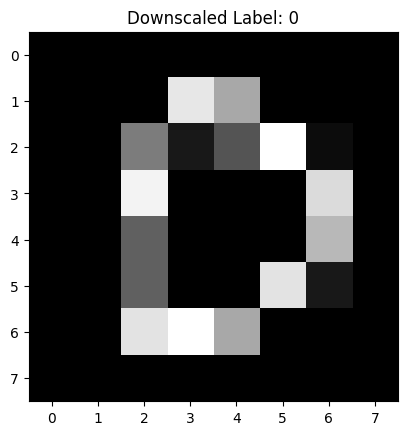

In [24]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define a custom transform with resize and conversion to tensor
transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.1381,)),
                                    transforms.Lambda(lambda img: F.interpolate(img.unsqueeze(0), size=(resized_dims_xy, resized_dims_xy), 
                                        mode='bilinear', align_corners=False).squeeze(0))
])

# Load MNIST dataset with the custom transform
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Access a sample for testing
image, label = mnist_train[np.random.randint(0, len(mnist_train))]

# No need for separate downscaling or conversion
plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove channel dimension (if needed)
plt.title(f'Downscaled Label: {label}')
plt.show()


In [25]:
def evaluate_population(population):
    return list(map(fitness, population))

In [26]:
def evolve():
    time_start = time.time()
    population = generate_population(population_size, n_gates)
    best_individual = None
    best_fitness = float('inf')
    population = evaluate_population(population)
    population.sort(key=lambda x: x[1])
    print(f"[t] Time to generate initial population of {population_size} circuits: {(time.time() - time_start):.3f}s")
    print(f"\t[i] n_train: {n_train}, n_test: {n_test},  batch_size: {batch_size}, n_epochs: {n_epochs}")
    print(f"\t[f] Best fitness: {100*-population[0][1]}%")
    print(f"\t[b] Best individual: {population[0][0]}")
    
    for i in range(n_generations):
        start_time = time.time()
        print(f"[i] Generation ({i+1}/{n_generations})")
        selected_population = select_circuits(population, population_size // 2 + 1)
        new_population = []

        for j in range(0, population_size // 2, 2):
            parent1 = selected_population[j]
            parent2 = selected_population[j+1]
            
            offspring1, offspring2 = uniform_crossover(parent1[0], parent2[0])
   
            new_population.append(offspring1)
            new_population.append(offspring2)

        new_population = evaluate_population(new_population)
        population = population +  new_population

        for individual in population:
            if np.random.random() < mutation_rate:
                new_population.append(mutate_circuit(individual[0]))

        population.sort(key=lambda x: x[1])

        population = population[:population_size]

        best_individual = population[0][0]
        best_fitness = population[0][1]

        print(f"\t[f] Best fitness: {100*-best_fitness}%")
        print(f"\t[b] Best individual: {best_individual}")
        print(f"\t[f]Average fitness: {100*-sum(get_population_fitnesses(population)) / len(population)}%")
        print(f"\t[t] Time per generation: {(time.time() - start_time):.3f}s")
            
    return population

final_population = evolve()

[t] Time to generate initial population of 500 circuits: 34083.913s
	[i] n_train: 500, n_test: 100,  batch_size: 32, n_epochs: 10
	[f] Best fitness: 64.0%
	[b] Best individual: [303, 211, 210, 323, 313, 312, 320, 323, 212]
[i] Generation (1/10)
	[f] Best fitness: 64.0%
	[b] Best individual: [303, 211, 210, 323, 313, 312, 320, 323, 212]
	[f]Average fitness: 58.974000000000196%
	[t] Time per generation: 23893.625s
[i] Generation (2/10)
	[f] Best fitness: 64.0%
	[b] Best individual: [303, 211, 210, 323, 313, 312, 320, 323, 212]
	[f]Average fitness: 59.55199999999991%
	[t] Time per generation: 23884.837s
[i] Generation (3/10)
	[f] Best fitness: 65.0%
	[b] Best individual: [122, 303, 200, 312, 320, 203, 233, 403]
	[f]Average fitness: 59.98399999999964%
	[t] Time per generation: 24732.293s
[i] Generation (4/10)


In [ ]:
def decode_to_code(encoded_circuit):
    weight_idx = 0
    for encoded_gate in encoded_circuit:
        wire2  = encoded_gate % 10
        wire1 = (encoded_gate // 10) % 10
        gate = (encoded_gate // 100) % 10

        if gate == 1:
            print(f"qml.RX(weights[{weight_idx}], wires={wire1})")
            weight_idx += 1
        elif gate == 2: 
            print(f"qml.RZ(weights[{weight_idx}], wires={wire1})")
            weight_idx += 1
        elif gate == 3:
            print(f"qml.CNOT(wires=[{wire1}, {wire2}])")
        elif gate == 4:
            print(f"qml.Hadamard(wires={wire1})")


for i in range(population_size):
    print(f"Individual {i+1}")
    print(final_population[i][0])
    print(f"Fitness: {100*-final_population[i][1]}%")
    decode_to_code(final_population[i][0])
    print("-" * 20)
    print("\n")

Individual 1
[212, 202]
Fitness: 65.0%
qml.RZ(weights[0], wires=1)
qml.RZ(weights[1], wires=0)
--------------------


Individual 2
[310, 410, 222, 301, 233, 200, 403, 103]
Fitness: 64.0%
qml.CNOT(wires=[1, 0])
qml.Hadamard(wires=1)
qml.RZ(weights[0], wires=2)
qml.CNOT(wires=[0, 1])
qml.RZ(weights[1], wires=3)
qml.RZ(weights[2], wires=0)
qml.Hadamard(wires=0)
qml.RX(weights[3], wires=0)
--------------------


Individual 3
[430, 102, 332, 402, 122, 410, 421, 103]
Fitness: 63.0%
qml.Hadamard(wires=3)
qml.RX(weights[0], wires=0)
qml.CNOT(wires=[3, 2])
qml.Hadamard(wires=0)
qml.RX(weights[1], wires=2)
qml.Hadamard(wires=1)
qml.Hadamard(wires=2)
qml.RX(weights[2], wires=0)
--------------------


Individual 4
[100, 312, 331]
Fitness: 63.0%
qml.RX(weights[0], wires=0)
qml.CNOT(wires=[1, 2])
qml.CNOT(wires=[3, 1])
--------------------


Individual 5
[403, 223, 403, 420, 210, 233]
Fitness: 62.0%
qml.Hadamard(wires=0)
qml.RZ(weights[0], wires=2)
qml.Hadamard(wires=0)
qml.Hadamard(wires=2)
qml.RZ(